In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/Sparks


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd


sc.logging.print_versions()

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.15.0
cloudpickle         2.2.1
cnmf                NA
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastcluster         1.2.6
fsspec              2023.1.0
h5py                3.6.0
igraph              0.9.9
ipykernel           6.13.0
ipython_genutils    0.2.0
jedi                0.18.1
jinja2              3.1.1
joblib              1.1.0
jupyter_server      1.16.0
kiwisolver          1.4.2
leidenalg           0.8.9
llvmlite            0.38.0
markupsafe          2.1.1
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.3
natsort             8.1

# Parameters

In [5]:
! ls ../../../Data/PerDataset/

AMPRA
COMBAT
HaoEtAl
Merged_ADT_Info_Cleaned.tsv
Merged_ADT_Info.tsv
Pancancer
Sparks2023
Stimseq
TBRU
TCAT_Simulation
TotalSeq_C_Human_Universal_Cocktail_v1_137_Antibodies_399905_Barcodes_Cleaned.xlsx
UKCOVID
XTissueImmuneAtlas


In [6]:
params = {
'harmony_vars' : ['Batch'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 70,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 31,
'n_adt_pcs' : 21,
'name_addition' : None, # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = '.'
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad'),
        'Filt_Cell_List':original.replace('.h5ad', toadd + 'FiltForcNMF.Cell_list.tsv')
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.h5ad',
 'Filt_Cell_List': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.Cell_list.tsv',
 'ADT_MI_Rank': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.RNA_and_ADT.HVGlist.tsv',
 'RNA_and_ADT_Varnorm_Harmony_WNN': '../../../D

In [7]:
import os
os.path.abspath(paths['RNA_Varnorm_Harmony'])

'/data/srlab1/TCAT/Data/PerDataset/Sparks2023/T_fromSeurat.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

# Run pipeline

In [8]:
adata = sc.read(paths['Original'])


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


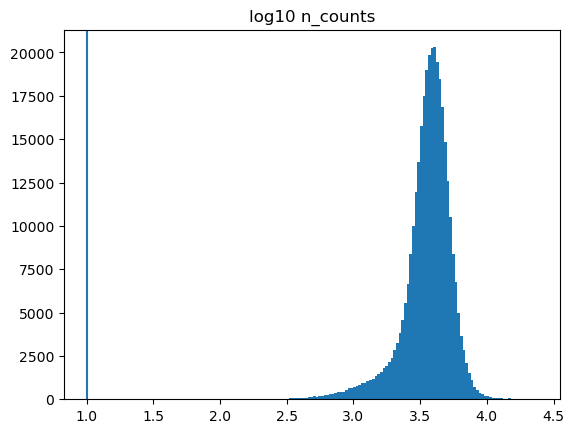

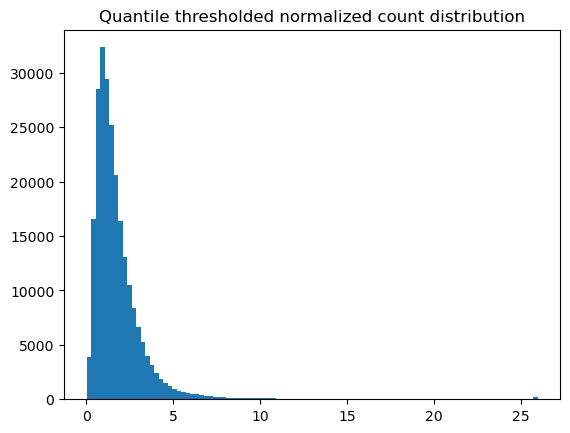

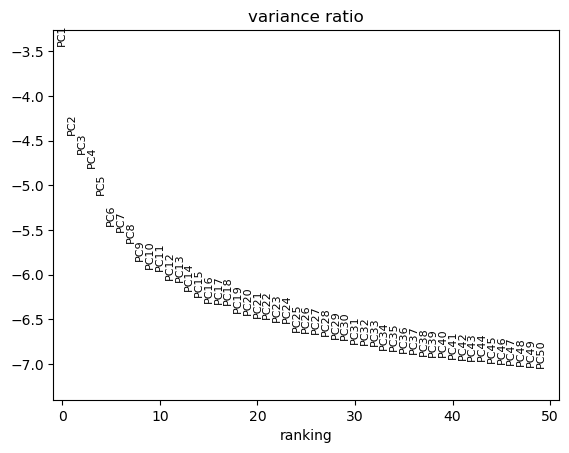

2023-11-25 20:54:35,597 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-11-25 20:56:13,299 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-11-25 20:56:50,477 - harmonypy - INFO - Iteration 1 of 20
2023-11-25 21:14:33,531 - harmonypy - INFO - Iteration 2 of 20
2023-11-25 21:32:47,110 - harmonypy - INFO - Iteration 3 of 20
2023-11-25 21:55:57,687 - harmonypy - INFO - Iteration 4 of 20
2023-11-25 22:14:07,889 - harmonypy - INFO - Iteration 5 of 20
2023-11-25 22:26:17,156 - harmonypy - INFO - Converged after 5 iterations
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [19]:

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [ ]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [ ]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

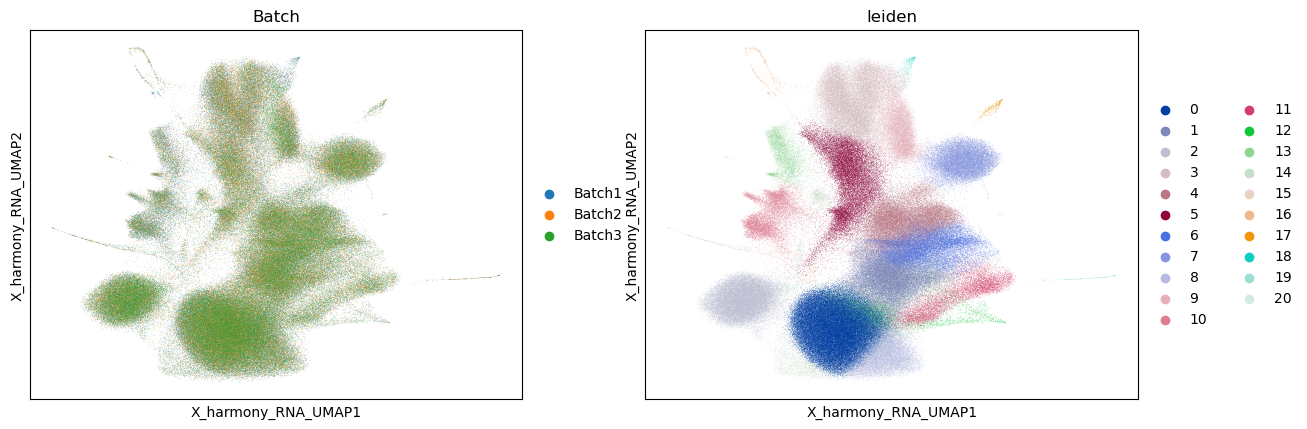

In [14]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [15]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [16]:
meta = pd.read_csv(paths['Metadata'], sep='\t', index_col=0)
adata_RNA_c.obs = meta.loc[adata_RNA_c.obs.index, :]

/tmp/ipykernel_60947/376388247.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(paths['Metadata'], sep='\t', index_col=0)


In [17]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [18]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [19]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((336739, 28540), (335906, 2000), (335906, 28540))

In [20]:
adata_RNA_c

AnnData object with n_obs × n_vars = 335906 × 2000
    obs: 'alt.subject.id', 'visit', 'covid.diagnosis.start.date.to.sample.drawn', 'group', 'sex', 'age', 'race', 'ethnicity', 'flu.vax.count.10yr', 'vaccine', 'vaccine.side.effects', 'long.covid.symptoms', 'Batch', 'nCount_RNA', 'nCount_HTO', 'nCount_CITE', 'nCount_RNA_largest.gene', 'nCount_SCT', 'nFeature_RNA', 'nFeature_HTO', 'nFeature_CITE', 'nFeature_SCT', 'percent.mt', 'percent.largest.gene', 'coarse.cell.type', 'cell.type', 'HTO1', 'HTO2', 'HTO3', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'features_renamed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'Batch_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_harmony_RNA_UMAP', 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.h5ad'

In [22]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

In [5]:
# adata_filt = sc.read(paths['Raw_Filt_For_cNMF'])

In [12]:
paths

{'Original': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.h5ad',
 'Filt_Cell_List': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.Cell_list.tsv',
 'ADT_MI_Rank': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.RNA_and_ADT.HVGlist.tsv',
 'RNA_and_ADT_Varnorm_Harmony_WNN': '../../../D

In [8]:
paths['Filt_Cell_List']

'../../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.Cell_list.tsv'

In [11]:
with open(paths['Filt_Cell_List'], 'w') as F:
    F.write('\n'.join(adata_filt.obs.index))